In [1]:
import numpy as np
import pandas as pd
import tmm

# imports and setup for tmm
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline


# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

# Import experimental data
In this example we will use just one angle of incidence

In [2]:
# Read the raw data file, skip the first three rows without a header and select the following 51 rows
raw_data = pd.read_csv('25 nm of SiO2.dat', sep = '\t', skiprows=3 , nrows=51 , header=None)
#Rename the columns of the raw data frame into relevant features
raw_data.columns = ['lambda_vac', 'th_0', 'psi_exp', 'delta_exp', 'psi_exp_sigma', 'delta_exp_sigma']

# Import Silicon refractive index
Monocrystalline Silicon refractive index data is imported from a tabulated list

In [3]:
from materials import (Si_nk_fn)

# Create a function-based refractive index for SiO$_2$

#In this case since SiO2 is a transparent material, the index of refraction n and absorption coefficient k can be described by a slowly varying function of wavelength, $\lambda$ (in um), and an exponential absorption tail, respectively. This model is called a Cauchy layer.

\begin{equation}
n(\lambda)=A+\frac{B}{\lambda^2}+\frac{C}{\lambda^4}
\tag{1}
\end{equation}
\begin{equation}
k(\lambda)=\alpha e^{\beta\left[1.24\mu m\left(\frac{1}{\lambda}-\frac{1}{\gamma}\right)\right]}
\tag{2}
\end{equation}

The parameters of this model are A, B, C, extintion coefficient amplitude $\alpha$, exponent factor $\beta$ and band edge $\gamma$ (in $\mu m$).


In [4]:
import math

def nk_cauchy(A,B,C,alpha, beta, gamma, lambda_vac):
    
#the values are entered in nm
    
    #convert to um
    lambda_vac_um=lambda_vac/1000
    gamma_um=gamma/1000
    
    #calculate n
    n_cauchy=A+B/(lambda_vac_um)**2+C/(lambda_vac_um)**4
    
    #calculate k
    k_cauchy=alpha*math.exp(beta*(1.24*((1/lambda_vac_um)-(1/gamma_um))))
    
    #return complex refractive index
    return complex(n_cauchy, k_cauchy);

# Define MSE
The mean squared error (MSE) is defined as a function of the thickness and parameters $A$, $B$ and $C$ of the Cauchy layer, which is modeled on top of a silicon substrate simulating an air/SiO$_2$/Si material.
Notice that we set $\alpha=0$ so that $k=0$ (see Eq.(2)), this is because SiO$_2$ is known to behave as a fully transparent material, in this case $\beta$ and $\gamma$ will not affect the model.

In [15]:
def MSE(params):
    
    #set the known parameters. 
    alpha=0
    beta=0
    gamma=400
    thickness,A,B,C= params
    
    #set number of layers and thickness
    d_list = [inf,thickness,inf] #in nm
    
    #set wavelength range
    lambda_list = linspace(300,800,51) #in nm
    
    # calculate psi and delta from the model 
    psi_mod=[]
    delta_mod=[]
    for lambda_vac in lambda_list:
                n_list = [1,nk_cauchy(A,B,C,alpha, beta, gamma, lambda_vac),Si_nk_fn(lambda_vac)]
                e_data=ellips(n_list, d_list, 65*degree, lambda_vac) #in nm
                psi_mod.append(e_data['psi']/degree) # angle in degrees
                delta_mod.append((pi-e_data['Delta'])/degree) # angle in degrees
    # make a dataframe with the values from the model
    mod=pd.DataFrame({"psi_mod":psi_mod,
                       "delta_mod":delta_mod})
    # calculate MSE
    xi=((mod['psi_mod'] - raw_data['psi_exp'])/(raw_data['psi_exp_sigma']))**2+((mod['delta_mod'] - raw_data['delta_exp'])/(raw_data['delta_exp_sigma']))**2
    MSE_calc=(xi.sum(axis=0)/(2*len(xi)-1))**(1/2)

    return MSE_calc

# Fit model to experimental data using local optimization
Find the parameters that give the minimum MSE. If the model is correct, this parameters are the best description to your sample. 

In [18]:
%%time
import scipy.optimize as optimize

#set initial parameters to start the optimization
initial_guess = [24, 1.5,0,0]

# set bound values for each parameter to be fitted
bounds = [(0,50), (1,3),(0,.5),(0,.5)]

#set parameters for optimization
result = optimize.minimize(MSE, initial_guess,bounds = bounds)

if result.success:
    fitted_params_local = result.x
    print('Fitted parameters:')
    print('thickness =',fitted_params_local[0])
    print('A=',fitted_params_local[1])
    print('MSE=', result.fun)
else:
    raise ValueError(result.message)

Fitted parameters:
thickness = 23.919758747562906
A= 1.5287117401743906
MSE= 4.587477421990948
Wall time: 4.27 s


# Fit model to experimental data using global optimization
Find the parameters that give the minimum MSE. If the model is correct, this parameters are the best description to your sample. 
The method used is differential evolution, the intial population is a random.

In [7]:
%%time
#use diferential evolution to find the global minimum
from scipy.optimize import differential_evolution

#set the bounds of the parameters to be fitted
bounds = [(0,50), (1,3),(0,.5),(0,.5)]

#set parameters for the model
result=differential_evolution(MSE, bounds, args=(), 
                                      strategy='best1bin', maxiter=100, popsize=10, tol=0.01, 
                                      mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, 
                                      disp=True, polish=True, init='latinhypercube', atol=0, 
                                     updating='immediate', workers=1, constraints=())

fitted_params = result.x
print('Fitted parameters:')
print('thickness =',fitted_params[0])
print('A=',fitted_params[1])
print('B=',fitted_params[2])
print('C=',fitted_params[3])
print('MSE=', result.fun)

differential_evolution step 1: f(x)= 169.094
differential_evolution step 2: f(x)= 128.951
differential_evolution step 3: f(x)= 128.951
differential_evolution step 4: f(x)= 96.1138
differential_evolution step 5: f(x)= 94.9024
differential_evolution step 6: f(x)= 88.0971
differential_evolution step 7: f(x)= 88.0971
differential_evolution step 8: f(x)= 74.0022
differential_evolution step 9: f(x)= 64.4068
differential_evolution step 10: f(x)= 64.4068
differential_evolution step 11: f(x)= 64.4068
differential_evolution step 12: f(x)= 53.606
differential_evolution step 13: f(x)= 44.5817
differential_evolution step 14: f(x)= 36.707
differential_evolution step 15: f(x)= 36.707
differential_evolution step 16: f(x)= 28.0097
differential_evolution step 17: f(x)= 26.8451
differential_evolution step 18: f(x)= 19.669
differential_evolution step 19: f(x)= 19.669
differential_evolution step 20: f(x)= 15.6602
differential_evolution step 21: f(x)= 15.6602
differential_evolution step 22: f(x)= 15.6602
di

# Calculate $\Psi(\lambda)$ and $\Delta(\lambda)$ using fitted parameters

In [8]:
#set the known parameters. 

alpha=0
beta=0
gamma=400 

#use the optimum parameters as the unknowns
thickness,A,B,C=fitted_params

#set number of layers and thickness
d_list = [inf,thickness,inf] #in nm

#set wavelength range
lambda_list = linspace(300,800,51) #in nm

# calculate psi and delta from the model 
psi_mod=[]
delta_mod=[]
for lambda_vac in lambda_list:
    n_list = [1,nk_cauchy(A,B,C,alpha, beta, gamma, lambda_vac),Si_nk_fn(lambda_vac)]
    e_data=ellips(n_list, d_list, 65*degree, lambda_vac) #in nm
    psi_mod.append(e_data['psi']/degree) # angle in degrees
    delta_mod.append((pi-e_data['Delta'])/degree) # angle in degrees

# Plot generated and experimental data

MSE= 4.587477421992727


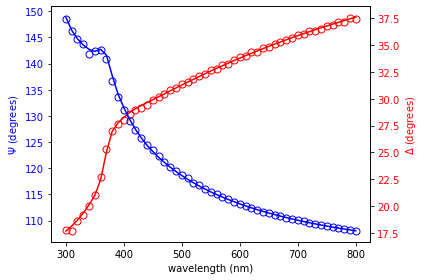

In [9]:
#print the MSE
print('MSE=',MSE(fitted_params))

# plot modeled and experimental delta
fig, ax1 = plt.subplots()

color = 'b'
ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('$\Psi$ (degrees)', color=color)
ax1.plot(lambda_list,delta_mod, 'r-', raw_data.lambda_vac ,raw_data.delta_exp, 'ro', markerfacecolor='none', ms=7, markeredgecolor='red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('$\Delta$ (degrees)', color=color)  # we already handled the x-label with ax1
ax2.plot(lambda_list , psi_mod ,'b-', raw_data.lambda_vac , raw_data.psi_exp,'bo', markerfacecolor='none', ms=7, markeredgecolor='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Using previous fitted parameters as initial guess
Here the initial population is given by a Gaussian distribution centered at the previous fitted parameters

In [19]:
%%time
#set the bounds of the parameters to be fitted
bounds = [(20,30), (1,2),(0,.1),(0,.1)]

#set initial guess for parameters
from random import seed
from random import gauss
# seed random number generator
seed(1)

x_0=[]
x_1=[]
x_2=[]
x_3=[]
# generate some Gaussian values around the previous fitted values with a standard deviation of 1%
for _ in range(15):
    x_0.append(gauss(fitted_params[0], fitted_params[0]*.1))
    x_1.append(gauss(fitted_params[1], fitted_params[1]*.1))
    x_2.append(gauss(fitted_params[2], fitted_params[2]*.1))
    x_3.append(gauss(fitted_params[3], fitted_params[3]*.1))
#write DataFrame with initial population
initial_guess=pd.DataFrame({"x_0":x_0,
                       "x_1":x_1,"x_2":x_2,"x_3":x_3})


#minimize MSE and display the best 
#result = differential_evolution(MSE, bounds,disp=True)
result=differential_evolution(MSE, bounds, args=(), 
                                      strategy='best1bin', maxiter=100, popsize=15, tol=0.01, 
                                      mutation=(0.5, 1), recombination=0.7, seed=None, callback=None, 
                                      disp=True, polish=True, init=initial_guess, atol=0, 
                                      updating='immediate', workers=1, constraints=())

fitted_params = result.x
print('Fitted parameters:')
print('thickness =',fitted_params[0])
print('A=',fitted_params[1])
print('B=',fitted_params[2])
print('C=',fitted_params[3])
print('MSE=', result.fun)

differential_evolution step 1: f(x)= 5.82144
differential_evolution step 2: f(x)= 5.82144
differential_evolution step 3: f(x)= 5.37275
differential_evolution step 4: f(x)= 5.37275
differential_evolution step 5: f(x)= 4.95506
differential_evolution step 6: f(x)= 4.71924
differential_evolution step 7: f(x)= 4.71924
differential_evolution step 8: f(x)= 4.70337
differential_evolution step 9: f(x)= 4.61383
differential_evolution step 10: f(x)= 4.60643
differential_evolution step 11: f(x)= 4.58995
differential_evolution step 12: f(x)= 4.58995
differential_evolution step 13: f(x)= 4.58886
differential_evolution step 14: f(x)= 4.58886
differential_evolution step 15: f(x)= 4.58776
differential_evolution step 16: f(x)= 4.58768
differential_evolution step 17: f(x)= 4.58768
Fitted parameters:
thickness = 23.915393566518805
A= 1.5289084079597328
B= 0.0
C= 0.0
MSE= 4.587561033049325
Wall time: 6.33 s


# Calculate $\Psi(\lambda)$ and $\Delta(\lambda)$ using fitted parameters

In [12]:
#set the known parameters. 
alpha=0
beta=0
gamma=400 

#use the optimum parameters as the unknowns
thickness,A,B,C=fitted_params

#set number of layers and thickness
d_list = [inf,thickness,inf] #in nm

#set wavelength range
lambda_list = linspace(300,800,51) #in nm

# calculate psi and delta from the model 
psi_mod=[]
delta_mod=[]
for lambda_vac in lambda_list:
    n_list = [1,nk_cauchy(A,B,C,alpha, beta, gamma, lambda_vac),Si_nk_fn(lambda_vac)]
    e_data=ellips(n_list, d_list, 65*degree, lambda_vac) #in nm
    psi_mod.append(e_data['psi']/degree) # angle in degrees
    delta_mod.append((pi-e_data['Delta'])/degree) # angle in degrees

# Plot generated and experimental data

MSE= 4.587571940840621


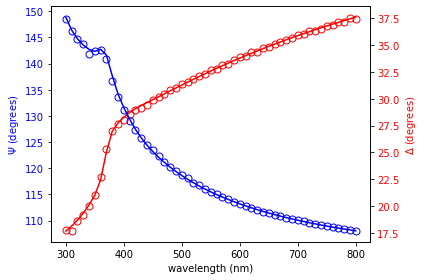

In [13]:
#print the MSE
print('MSE=',MSE(fitted_params))

# plot modeled and experimental delta
fig, ax1 = plt.subplots()

color = 'b'
ax1.set_xlabel('wavelength (nm)')
ax1.set_ylabel('$\Psi$ (degrees)', color=color)
ax1.plot(lambda_list,delta_mod, 'r-', raw_data.lambda_vac ,raw_data.delta_exp, 'ro', markerfacecolor='none', ms=7, markeredgecolor='red')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'r'
ax2.set_ylabel('$\Delta$ (degrees)', color=color)  # we already handled the x-label with ax1
ax2.plot(lambda_list , psi_mod ,'b-', raw_data.lambda_vac , raw_data.psi_exp,'bo', markerfacecolor='none', ms=7, markeredgecolor='blue')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()